# Optimization of a taper structure using Nevergrad

This file shows how to use the Nevergrad optimization library to optimize a taper photonic structure. 

We first import all the modules needed.

In [25]:
import numpy as np # to create Matlab-like arrays
import matplotlib.pyplot as plt # to visualize results
import nevergrad as ng # to perform the optimization

## Compute the transmission coefficient

We define then the functions needed to compute the reflection and transmission coefficients of propagative modes in a structure, by using a scattering matrix formalism and a RCWA method.  

In [26]:
def cascade(T,U):
    '''Cascading of two scattering matrices T and U.
    Since T and U are scattering matrices, it is expected that they are square
    and have the same dimensions which are necessarily EVEN.
    '''
    n = int(T.shape[1] / 2)
    J = np.linalg.inv( np.eye(n) - np.matmul(U[0:n,0:n],T[n:2*n,n:2*n] ) )
    K = np.linalg.inv( np.eye(n) - np.matmul(T[n:2*n,n:2*n],U[0:n,0:n] ) )
    S = np.block([[T[0:n,0:n] + np.matmul(np.matmul(np.matmul(T[0:n,n:2*n],J),
    U[0:n,0:n]),T[n:2*n,0:n]),np.matmul(np.matmul(T[0:n,n:2*n],J),U[0:n,n:2*n])
    ],[np.matmul(np.matmul(U[n:2*n,0:n],K),T[n:2*n,0:n]),U[n:2*n,n:2*n]
    + np.matmul(np.matmul(np.matmul(U[n:2*n,0:n],K),T[n:2*n,n:2*n]),U[0:n,n:2*n])
    ]])
    return S

def c_bas(A,V,h):
    ''' Directly cascading any scattering matrix A (square and with even
    dimensions) with the scattering matrix of a layer of thickness h in which
    the wavevectors are given by V. Since the layer matrix is
    essentially empty, the cascading is much quicker if this is taken
    into account.
    '''
    n = int(A.shape[1]/2)
    D = np.diag(np.exp(1j*V*h))
    S = np.block([[A[0:n,0:n],np.matmul(A[0:n,n:2*n],D)],[np.matmul(D,A[n:2*n,0:n]),np.matmul(np.matmul(D,A[n:2*n,n:2*n]),D)]])
    return S

def c_haut(A,valp,h):
    n = int(A[0].size/2)
    D = np.diag(np.exp(1j*valp*h))
    S11 = np.dot(D,np.dot(A[0:n,0:n],D))
    S12 = np.dot(D,A[0:n,n:2*n])
    S21 = np.dot(A[n:2*n,0:n],D)
    S22 = A[n:2*n,n:2*n]
    S1 = np.append(S11,S12,1)
    S2 = np.append(S21,S22,1)
    S = np.append(S1,S2,0)
    return S    

def step(a,b,w,x0,n):
    '''Computes the Fourier series for a piecewise function having the value
    b over a portion w of the period, starting at position x0
    and the value a otherwise. The period is supposed to be equal to 1.
    Then returns the toeplitz matrix generated using the Fourier series.
    '''
    from scipy.linalg import toeplitz
    from numpy import sinc
    l = np.zeros(n,dtype=np.complex128)
    m = np.zeros(n,dtype=np.complex128)
    tmp = np.exp(-2*1j*np.pi*(x0+w/2)*np.arange(0,n))*sinc(w*np.arange(0,n))*w
    l = np.conj(tmp)*(b-a)
    m = tmp*(b-a)
    l[0] = l[0]+a
    m[0] = l[0]
    T = toeplitz(l,m)
    return T

def fpml(q,g,n):
    from scipy.linalg import toeplitz
    from numpy import sinc,flipud
    x = np.arange(-n,n+1)
    v = -q/2*((1+g/4)*sinc(q*x)+(sinc(q*x-1)+sinc(q*x+1))*0.5-g*0.125*(sinc(q*x-2)+sinc(q*x+2)))
    v[n] = v[n]+1
    T = toeplitz(flipud(v[1:n+1]),v[n:2*n])
    return T

def aper(k0,a0,pol,e1,e2,n,blocs):
    '''Warning: blocs is a vector with N lines and 2 columns. Each
    line refers to a block of material e2 inside a matrix of material e1,
    giving its size relatively to the period (first column) and its starting
    position.
    Warning : There is nothing checking that the blocks don't overlapp.
    '''
    n_blocs = blocs.shape[0];
    nmod = int(n/2)
    M1 = e1*np.eye(n,n)
    M2 = 1/e1*np.eye(n,n)
    for k in range(0,n_blocs):
        M1 = M1+step(0,e2-e1,blocs[k,0],blocs[k,1],n)
        M2 = M2+step(0,1/e2-1/e1,blocs[k,0],blocs[k,1],n)
    alpha = np.diag(a0+2*np.pi*np.arange(-nmod,nmod+1))+0j
    g = 1/(1-1j);
    fprime = np.eye(n)
    if (pol==0):
        tmp = np.linalg.inv(fprime)
        M = np.matmul(tmp, np.matmul(alpha, np.matmul(tmp, alpha)))\
        -k0*k0*M1
        L,E = np.linalg.eig(M)
        L = np.sqrt(-L+0j)
        L = (1-2*(np.imag(L)<-1e-15))*L
        P = np.block([[E],[np.matmul(E,np.diag(L))]])
    else:
        M = np.matmul(np.linalg.inv(np.matmul(fprime, M2)),\
        -k0*k0*fprime+np.matmul(alpha, np.matmul(np.linalg.inv(np.matmul(M1, fprime)), alpha)))
        L,E = np.linalg.eig(M)
        L = np.sqrt(-L+0j)
        L = (1-2*(np.imag(L)<-1e-15))*L
        P = np.block([[E],[np.matmul(np.matmul(M2,E),np.diag(L))]])
    return P,L

def interface(P,Q):
    '''Computation of the scattering matrix of an interface, P and Q being the
    matrices given for each layer by homogene, reseau or creneau.
    '''
    n = int(P.shape[1])
    S = np.matmul(np.linalg.inv(np.block([[P[0:n,0:n],-Q[0:n,0:n]],[P[n:2*n,0:n],Q[n:2*n,0:n]]])),np.block([[-P[0:n,0:n],Q[0:n,0:n]],[P[n:2*n,0:n],Q[n:2*n,0:n]]]))
    return S

def intermediaire(T,U):
    n = int(T.shape[0] / 2)
    H = np.linalg.inv( np.eye(n) - np.matmul(U[0:n,0:n],T[n:2*n,n:2*n]))
    K = np.linalg.inv( np.eye(n) - np.matmul(T[n:2*n,n:2*n],U[0:n,0:n]))
    a = np.matmul(K, T[n:2*n,0:n])
    b = np.matmul(K, np.matmul(T[n:2*n,n:2*n],U[0:n,n:2*n]))
    c = np.matmul(H, np.matmul(U[0:n,0:n],T[n:2*n,0:n]))
    d = np.matmul(H,U[0:n,n:2*n]) 
    S = np.block([[a,b],[c,d]])
    return S

def couche(valp, h):
    n = len(valp)
    AA = np.diag(np.exp(1j*valp*h))
    C = np.block([[np.zeros((n,n)),AA],[AA,np.zeros((n,n))]])
    return C


## Define the cost function

The cost function is in the `taper` function. We consider 25 modes, a period (d) of 1500 nm (to assure that the period is sufficiently long for the different tapers do not interfere). We excited a waveguide of 120 nm with a 1550 nm wavelength, in polarization TE (s-polarization), with a normal angle of incidence. The goal of the optimization is to maximise the transmission coefficient of the fundamental mode from the 120 nm waveguide to a 450 nm waveguide using a structure to be optimized. 

In [27]:
def taper(X):
# X is a (n_layers x 2) matrix. The first column are the thicknesses,
# the second column are the widths of the waveguides. The positions of the waveguides are imposed.
# Number of modes retained (odd number); 31 is suffisent
    n=25 # total number of modes 
    d=1500 # period in nanometers
    n_layers=int(X.shape[0]) # number of layers
    n_cubes = 1 # number of blocs in a layer
    lam=1550 # excitation wavelength
    pol=0 # polarization (0 for TE, 1 otherwise)
    a0=0
    e1=2.1316 # permittivity of the first material 
    e2=12.11 # permittivity of the second material 
    # Definition of the variables
    # Adimensionalization
    x=X/d # all the structure
    t = X[:,0] # thicknesses
    t = t/d # again, thicknesses
    w = X[:,1] # widths of the blocs in each layer
    w = w/d; # again widths
    p = 0.5 - w/2 # position of the blocs in each layer : set as central in the period
    w_in=120/d # width of the incoming waveguide
    w_out=450/d # width of the outcoming waveguide
    l=lam/d # wavelength 
    k0=2*np.pi/l 
    bloc_in=np.array([[w_in,0.5-w_in/2]]) # incoming waveguide
    bloc_out=np.array([[w_out,0.5-w_out/2]]) # outcoming waveguide
    # Starting with neutral S matrix
    S=np.block([[np.zeros([n,n]),np.eye(n,dtype=np.complex128)],[np.eye(n),np.zeros([n,n])]])
    P,V=aper(k0,a0,pol,e1,e2,n,bloc_in)
    a=np.argmin(abs(V-2.35*k0)) #incoming waveguide, 2.35 = effective index
    for k in range(0,n_layers):
        cubes = np.array([[w[k],p[k]]])
        P_new,V_new=aper(k0,a0,pol,e1,e2,n,cubes)
        S=cascade(S,interface(P,P_new))
        S=c_bas(S,V_new,t[k])
        P,V=P_new,V_new
    P_out,V_out=aper(k0,a0,pol,e1,e2,n,bloc_out)
    S=cascade(S,interface(P,P_out))
    b=np.argmin(abs(V_out-3.24033*k0)) #output waveguide, 3.24 = effective index    
    cost=1-abs(S[b+n,a])**2
    return cost

## Define the parametrization of the optimization (the parameters forms)

For each optimization we need to define some `parametrization` defining the type of variables to optimize. Those variables can be continuous or discrete, and of any dimension. Here, we let the variables take values between 10 and 1500 nm (that is coherent to optimize thicknesses and widths of the blocs in the layers). As we using essentially evolutionary algorithms, some `child` is created. 

Here, we define the `reference child` by a suite of 200 nm layers in which blocs of 500 nm are placed. Otherwise, the child is by default a 0s vector and the optimization will not run because the child in not in the optimization domain.  

In [28]:
# The parameters to optimized are stored in a 2D array of number layers values x 2
number_layers = 4 
parametrization = ng.p.Array(shape=(number_layers,2)) 

# We create an initialized structure. The values are 0 by default.  
child = parametrization.spawn_child() 
print("value of the child before: ", child.value)

# We change the initial values from [0,0] to [200,500] nm, as we don't want layers 
# (or blocs) of 0 nm thicknesses (or widths)
child.value = [[200,500]]*number_layers
print("value of the child after : ", child.value)

# We store this structure as the initialized structures for the next steps of 
# optimization
parametrization.value = child.value

# We set the lower and upper values authorized for the thicknesses and widths
parametrization = parametrization.set_bounds(lower=10, upper=1500)
print("parametrization", parametrization)


value of the child before:  [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
value of the child after :  [[200 500]
 [200 500]
 [200 500]
 [200 500]]
parametrization Array{(4,2),Cl(10,1500,b)}:[[200 500]
 [200 500]
 [200 500]
 [200 500]]


## Run the optimization

We can use many algorithms by using Nevergrad. Here, we use `TwoPointsDE`, and we give a `budget` of 100 to run the optimization. This `budget` is the number of times the cost function will be calculated. The optimization finishes when all the budget is used. We need to ensure that the chosen budget is sufficient to let the algorithm converges to a solution (see figure 1).

It is in the loop that the optimization performs. The `ask()` function generates some new structure, and we compute the `loss` (the value of the cost function) of this structure using the `func(x.value)` function. The optimization has in memory all the structures tested, so by using `recommendation()` method we ask wich structure is the best for now. The `loss2` array save the values of the best cost functions obtained after each iteration of the algorithm. 

`best` is a vector with the thicknesses of the structure.

`cf_best` is a vector with the associate cost function value. 

In [29]:
# We set the optimizer "TwoPointsDE" with a budget of 100 evaluations of the cost 
# function and the parametrization defined above
optim = ng.optimizers.registry["TwoPointsDE"](parametrization, budget =100)

# We initialized two arrays to store the data
loss = np.empty(optim.budget)
loss2 = np.empty(optim.budget)

# for each iteration of the optimization, we create a structure x, we compute its 
# cost function and store it in the 'loss' and 'loss2' arrays.
for i in range(optim.budget):
    x = optim.ask() # creation of a structure
    loss[i] = taper(x.value) # compute the cost function of the 'x' structure
    optim.tell(x, loss[i]) # i don't know why this line is useful, but it is. If 
    # it is commented, the code doesn't run.
    reco2 = optim.provide_recommendation() # provide the best structure computed 
    #for now
    loss2[i] = taper(reco2.value) # store the best cost function obtained for now

best = reco2.value # store the best structure obtained with the optimization process
cf_best = taper(best) # store the best cost function obtained with the optimization
# process


## Analyse the solution

### Individual analyse of a solution

Write the best structure and its cost function associated, trace the convergence curve of the optimization. 

best =  [[1142.39707118  300.54454715]
 [  79.66893237  587.54174074]
 [ 752.95858808  389.55395675]
 [ 148.08483118 1442.49338327]]
best cost function =  0.2931723314351983


Text(0.5, 1.0, 'Convergence curve of the optimization')

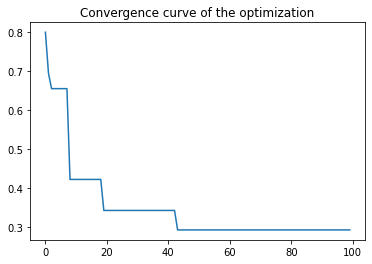

In [30]:
print("best = ", best) # display the best structure
print("best cost function = ", cf_best) # display the best cost function value

# display the convergence curve of the optimization. 
# The value of the convergence have to stuck. If not, the budget is not sufficient
plt.figure(1)
plt.plot(loss2)
plt.title("Convergence curve of the optimization")

We then represent the structure optimized using the `show_structure()` function.

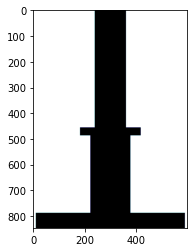

In [31]:
def show_structure(best):
    number_layers = int(best.shape[0])
    n_cubes = 1
    d = 1500
    t = best[:,0]
    w = best[:,1]
    p = (d-w)/2

    X = np.array([t, w, p])
    X = X.T

    h = t/d
    x = X/d

    n = 600
    H = sum(h)
    M0 = np.zeros((n))
    for j in range(number_layers):
        tmp = np.zeros(n)
        position = np.arange(1,n+1)/n
        for k in range(int((X.shape[1]-1)/2)):
            tmp = tmp + (position>x[j,2*k+2])*(position<x[j,2*k+1]+x[j,2*k+2])
        if (x[j,2*k+1]+x[j,2*k+2]>1):
            tmp = tmp + (position<x[j,2*k+1]+x[j,2*k+2]-1)
        cst = int(np.floor(h[j]*n))
        M2 = np.tile(tmp,(cst,1))
        if (j == 0):
            M = M2
        else:
            M = np.vstack((M,M2))

    M = 1 - M  
    return M

M = show_structure(best)
plt.figure(2)
plt.imshow(M*127, cmap = 'bone')
plt.show(block = False)    

We add functions to represent the field map of the optimized structure.

`HErmes()` function compute the amplitudes of the TE and TM fields by summing the amplitudes of each mode in a layer. 

`show_field()` function compute the upcoming and outgoing amplitudes of the modes in all the structure using the `HErmes()` data computed in each layers. 

` Field()` function define the important data needed in the `show_field()` function.

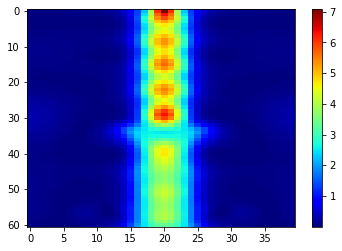

In [32]:
def HErmes(T,U,V,P,Amp,ny,h,a0):
    n = int(np.shape(T)[0] / 2)
    nmod = int((n-1) / 2)
    nx = n
    X = np.matmul(intermediaire(T,cascade(couche(V,h),U)),Amp.reshape(Amp.size,1))
    D = X[0:n]
    X = np.matmul(intermediaire(cascade(T,couche(V,h)),U),Amp.reshape(Amp.size,1))
    E = X[n:2*n]
    M = np.zeros((ny,nx-1), dtype = complex)
    for k in range(ny):
        y = h / ny * (k+1)
        Fourier = np.matmul(P,np.matmul(np.diag(np.exp(1j*V*y)),D) + np.matmul(np.diag(np.exp(1j*V*(h-y))),E))
        MM = np.fft.ifftshift(Fourier[0:len(Fourier)-1])
        M[k,:] = MM.reshape(len(MM))
    M = np.conj(np.fft.ifft(np.conj(M).T, axis = 0)).T * n
    x, y = np.meshgrid(np.linspace(0,1,nx-1), np.linspace(0,1,ny))
    M = M * np.exp(1j * a0 * x)
    return M

def show_field(k0,a0,A,thickness, exc,periode):
    n = len(A[0][1]) #5
    n_couches = thickness.shape[0] #3
    S11=np.zeros((n,n))
    S12=np.eye(n)
    S1=np.append(S11,S12,axis=0)
    S2=np.append(S12,S11,axis=0)
    S0=np.append(S1,S2,1)

    B = []
    for k in range(n_couches-1):
        a = np.array(A[k][0])
        b = np.array(A[k+1][0])
        c = interface(a,b)
        c = c.tolist()
        B.append(c)

    S = []
    S0 = S0.tolist()
    S.append(S0)

    for k in range(n_couches-1):
        a = np.array(S[k])
        b = c_haut(np.array(B[k]),np.array(A[k][1]),thickness[k])
        S_new = cascade(a,b) 
        S.append(S_new.tolist())

    a = np.array(S[n_couches-1])
    b = np.array(A[n_couches-1][1])
    c = c_bas(a,b,thickness[n_couches-1])
    S.append(c.tolist())

    Q = []
    Q.append(S0)

    for k in range(n_couches-1):
        a = np.array(B[n_couches-k-2])
        b = np.array(A[n_couches-(k+1)][1])
        c = thickness[n_couches-(k+1)]
        d = np.array(Q[k])
        Q_new = cascade(c_bas(a,b,c),d)
        Q.append(Q_new.tolist())

    a = np.array(Q[k])
    b = np.array(A[0][1])
    c = c_haut(a,b,thickness[n_couches-(k+1)])
    Q.append(c.tolist())

    stretch = periode / n

    M = HErmes(np.array(S[0]), np.array(Q[n_couches-0-1]), np.array(A[0][1]), np.array(A[0][0])[0:n,0:n],exc,int(np.floor(thickness[0] * periode / stretch)), thickness[0], a0)

    for j in np.arange(1,n_couches):
        M_new = HErmes(np.array(S[j]), np.array(Q[n_couches-j-1]), np.array(A[j][1]), np.array(A[j][0])[0:n,0:n],exc,int(np.floor(thickness[j] * periode / stretch)), thickness[j], a0) 
        M = np.append(M,M_new, 0)
    return M

def Field(X):
    nmod = 20
    n = 2*nmod+1
    periode = 1500
    number_layers = int(best.shape[0])
    n_cubes = 1
    lam = 1550
    pol = 0
    a0 = 0
    e1 = 2.1316
    e2 = 12.11
    t = best[:,0] / periode
    w = best[:,1] / periode
    p = 0.5 - w / 2 
    w_in = 120 / periode 
    w_out = 450 / periode 
    x = best / periode

    thickness = np.append(np.append(100 / periode, t), 100 / periode)
    l = lam / periode 
    k0 = 2 * np.pi / l 

    P_in,V_in = aper(k0,a0,pol,e1,e2,n,np.array([[w_in, 0.5-w_in/2]]))
    a = np.argmin(abs(V_in-2.35*k0)) 
    A = []
    A.append([P_in.tolist(),V_in.tolist()])
    for k in range(number_layers):
        cubes = np.array([[w[k],p[k]]])
        P_new,V_new=aper(k0,a0,pol,e1,e2,n,cubes)
        A.append([P_new.tolist(),V_new.tolist()])
    P_out, V_out = aper(k0,a0,pol,e1,e2,n,np.array([[w_out,0.5-w_out/2]]))
    a = np.argmin(abs(V_out-2.35*k0)) 
    A.append([P_out.tolist(),V_out.tolist()])
    exc = np.zeros(2*n)
    exc[a-1] = 1

    M = show_field(k0, a0, A, thickness, exc, periode)
    return M 
    
Mfield = Field(best)
Mfield = np.abs(Mfield)**2
plt.figure(3)
plt.imshow(Mfield, cmap = 'jet', aspect = 'auto')
plt.colorbar()
plt.show(block=False) # block = False is not needed in the Notebook, but I need it 
# when I run the code in local. 